In [ ]:
# google cloud lib req
#!pip install --user gcsfs statsmodels

In [1]:
# Import Libraries
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import datetime
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
import itertools
import warnings
warnings.filterwarnings("ignore")

In [2]:
#  Load the Data using Apple’s stock price data over the last 10 years, stored in a Google Cloud Storage bucket.
df = pd.read_csv('gs://cloud-training/ai4f/AAPL10Y.csv')
#df = pd.read_csv('aapl_2014_2023.csv')
df['date'] = pd.to_datetime(df['date'])
df.sort_values('date', inplace=True)
df.set_index('date', inplace=True)
df.head()

,close,volume,open,high,low
date,,,,,
2009-06-03,20.1357,140628992.0,20.0000,20.1586,19.8671
2009-06-04,20.5343,136628071.0,20.0186,20.5971,20.0057
2009-06-05,20.6671,157944127.0,20.7586,20.9143,20.4586
2009-06-08,20.5500,232466290.0,20.5457,20.6043,19.9186
2009-06-09,20.3886,168830811.0,20.5443,20.6514,20.0786


In [3]:
# Select only the specified columns
df_selected = df[['close']]
# Display the result
df_selected.head()

,close
date,
2009-06-03,20.1357
2009-06-04,20.5343
2009-06-05,20.6671
2009-06-08,20.5500
2009-06-09,20.3886


In [4]:
# Resample the data to weekly frequency and take the mean of 'close'
#df['close'] = pd.to_numeric(df['close'], errors='coerce')# Convert 'close' to numeric in case it's not in numeric format
df_week = df_selected.resample('W').mean()
df_week.head()

,close
date,
2009-06-07,20.445700
2009-06-14,20.106860
2009-06-21,19.525140
2009-06-28,19.711440
2009-07-05,20.258925


In [5]:
#  computing the logarithmic weekly returns to normalize the data.
df_week['weekly_ret'] = np.log(df_week['close']).diff()
df_week.dropna(inplace=True)
df_week.head()

,close,weekly_ret
date,,
2009-06-14,20.106860,-0.016712
2009-06-21,19.525140,-0.029358
2009-06-28,19.711440,0.009496
2009-07-05,20.258925,0.027396
2009-07-12,19.603160,-0.032905


# Exploratory Data Analysis

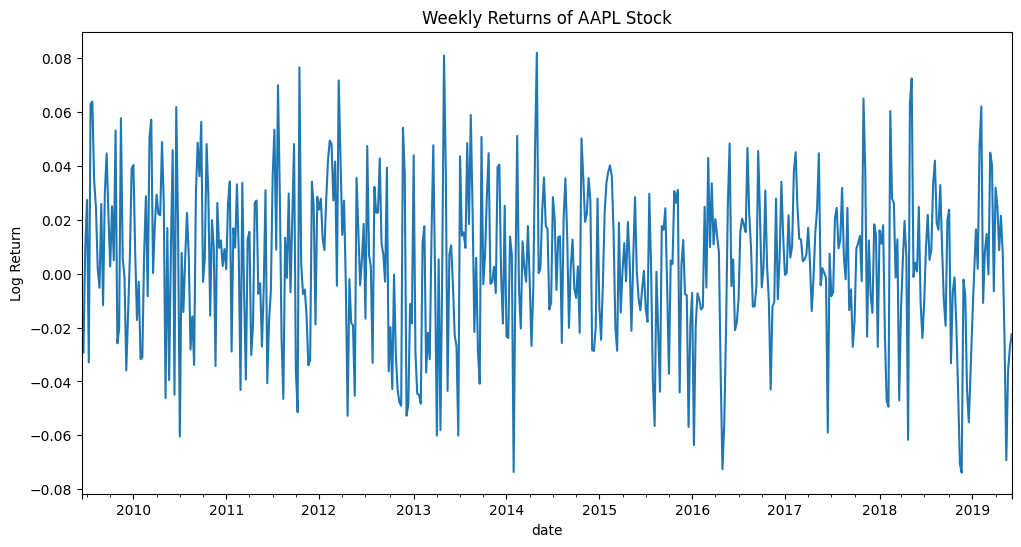

In [6]:
# visualizing the weekly returns.
df_week['weekly_ret'].plot(kind='line', figsize=(12, 6))
plt.title('Weekly Returns of AAPL Stock')
plt.ylabel('Log Return')
plt.show()

# Testing for Stationarity
- stationary time series has a constant mean and variance over time, which is a prerequisite for ARIMA modelling.
- computing the rolling mean and standard deviation.

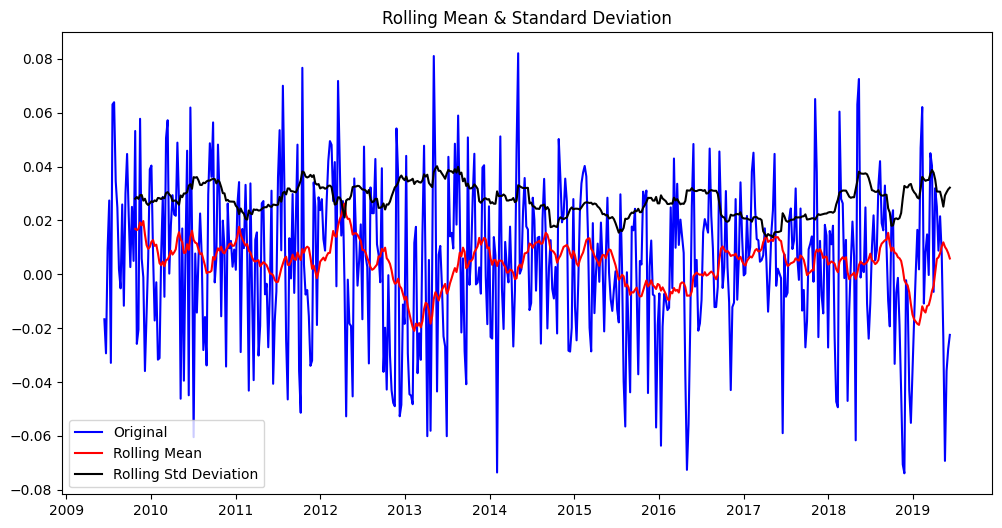

In [7]:
rolmean = df_week['weekly_ret'].rolling(window=20).mean()
rolstd = df_week['weekly_ret'].rolling(window=20).std()

plt.figure(figsize=(12, 6))
plt.plot(df_week['weekly_ret'], color='blue', label='Original')
plt.plot(rolmean, color='red', label='Rolling Mean')
plt.plot(rolstd, color='black', label='Rolling Std Deviation')
plt.title('Rolling Mean & Standard Deviation')
plt.legend()
plt.show()

In [8]:
# Augmented Dickey-Fuller test to statistically check stationarity.
dftest = sm.tsa.adfuller(df_week['weekly_ret'], autolag='AIC')
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '# Lags Used', 'Number of Observations Used'])
for key, value in dftest[4].items():
    dfoutput[f'Critical Value ({key})'] = value
print(dfoutput)

Test Statistic                -1.105002e+01
p-value                        5.107869e-20
# Lags Used                    2.000000e+00
Number of Observations Used    5.190000e+02
Critical Value (1%)           -3.443013e+00
Critical Value (5%)           -2.867125e+00
Critical Value (10%)          -2.569745e+00
dtype: float64


Interpretation:
- If the p-value is less than 0.05, the time series is stationary.

- Test Statistic: The test statistic is approximately -14.64, which is much lower than any of the critical values at the 1%, 5%, and 10% significance levels.
- p-value: The p-value is extremely low (3.61×10 −27), which is well below the typical significance levels (e.g., 0.05 or 0.01). **This indicates that we can reject the null hypothesis of non-stationarity.**
- Critical Values: The test statistic is significantly lower than the critical values at all tested levels (1%, 5%, and 10%), reinforcing the conclusion that the data is stationary.
  
**In summary, both the p-value and the test statistic strongly suggest rejecting the null hypothesis, indicating that the data is stationary. Hence we can proceed with the ARIMA forecasting**

# Identifying ARIMA Parameters
- to identify the optimal ARIMA parameters (p, d, q) for the  dataset.
- This process involves using the Autocorrelation Function (ACF) and Partial Autocorrelation Function (PACF) plots to help determine suitable values for p and q, while d is set based on the stationarity of the data.
- ACF and PACF Analysis: These plots help us visually decide on the values of p and q. The ACF shows the correlation of a time series with its lagged values, helping identify the q parameter, and the PACF helps determine p

In [9]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.stattools import acf, pacf

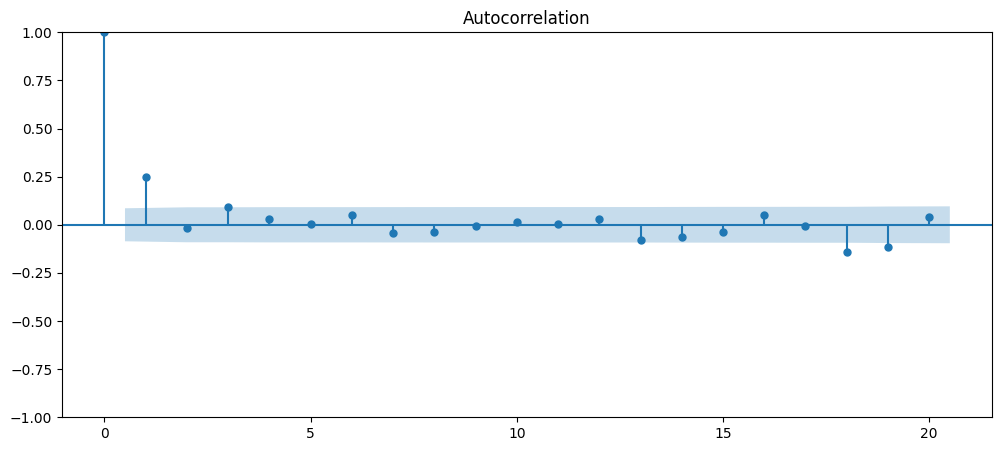

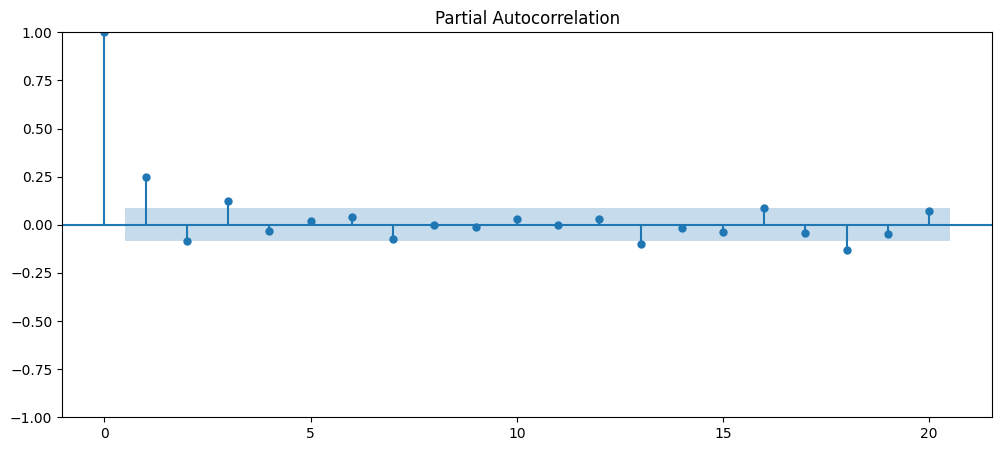

In [10]:
# Step 1: Plot ACF to estimate q
fig, ax = plt.subplots(figsize=(12,5))
plot_acf(df_week['weekly_ret'], lags=20, ax=ax)
plt.show()

# Step 2: Plot PACF to estimate p
fig, ax = plt.subplots(figsize=(12,5))
plot_pacf(df_week['weekly_ret'], lags=20, ax=ax)
plt.show()

In [11]:
acf_values = acf(df_week['weekly_ret'], nlags=20)  # Adjust `nlags` as needed
pacf_values = pacf(df_week['weekly_ret'], nlags=20)  # Adjust `nlags` as needed

# Display the values
acf_values_df = pd.DataFrame({'Lag': range(len(acf_values)), 'ACF': acf_values})
pacf_values_df = pd.DataFrame({'Lag': range(len(pacf_values)), 'PACF': pacf_values})
print("ACF values:\n", acf_values_df)
print("\nPACF values:\n", pacf_values_df)

ACF values:
     Lag       ACF
0     0  1.000000
1     1  0.246795
2     2 -0.018607
3     3  0.090926
4     4  0.028630
5     5  0.004800
6     6  0.051658
7     7 -0.043589
8     8 -0.037104
9     9 -0.004393
10   10  0.012951
11   11  0.003788
12   12  0.028788
13   13 -0.077875
14   14 -0.064932
15   15 -0.037236
16   16  0.050859
17   17 -0.008798
18   18 -0.142513
19   19 -0.113002
20   20  0.040066

PACF values:
     Lag      PACF
0     0  1.000000
1     1  0.247269
2     2 -0.085018
3     3  0.126048
4     4 -0.032763
5     5  0.020220
6     6  0.039517
7     7 -0.075149
8     8  0.001311
9     9 -0.014406
10   10  0.028291
11   11 -0.003028
12   12  0.032801
13   13 -0.102849
14   14 -0.015704
15   15 -0.040875
16   16  0.089393
17   17 -0.045343
18   18 -0.133751
19   19 -0.049168
20   20  0.072683


*Observation*
- ACF and PACF Analysis: These plots help us visually decide on the values of p and q. The ACF shows the correlation of a time series with its lagged values, helping identify the q parameter, and the PACF helps determine p
- Based on the ACF and PACF patterns:
p = 1 (AR term from PACF)
q = 1 (MA term from ACF)
d = 0 (assuming stationarity based on previous results).

# Hyperparameter Tuning
- to automate finding the best (p, d, q), we can run a grid search over a range of values and select the parameters with the lowest AIC (Akaike Information Criterion) and MSE (Mean Squared Error).
- To enhance ARIMA model selection process by incorporating Mean Squared Error (MSE) along with Akaike Information Criterion (AIC).
- This approach ensures that I select the best ARIMA model based on both AIC (which indicates model fit) and MSE (which measures forecasting accuracy).
- divide the dataset into a training set (60%) and a testing set (40%).
- fit model on the training set and forecast values for the testing set.bMSE is calculated between the actual test values and the predicted values.
- model with the lowest AIC is retained. In case of ties in AIC, it favours the one with the lowest MSE.

In [12]:
# Assuming df_week is your DataFrame and 'weekly_ret' is the column of interest
# Set initial range for p, d, and q
p = range(0, 4)  # Adjust range if necessary
d = range(0, 1)  # Typically, d = 0 or 1 if data is stationary
q = range(0, 4)

# Prepare to store the best results
best_aic = float("inf")
best_mse = float("inf")
best_order = None

# Grid search over the p, d, q values
for i in p:
    for j in d:
        for k in q:
            try:
                # Fit the ARIMA model
                model = ARIMA(df_week['weekly_ret'], order=(i, j, k))
                model_fit = model.fit()

                # Calculate AIC
                aic = model_fit.aic

                # Make predictions for MSE calculation (using the last 10% of the data as test set)
                train_size = int(len(df_week) * 0.9)
                train, test = df_week['weekly_ret'][:train_size], df_week['weekly_ret'][train_size:]
                model = ARIMA(train, order=(i, j, k))
                model_fit = model.fit()

                # Forecast the test set
                predictions = model_fit.forecast(steps=len(test))
                mse = mean_squared_error(test, predictions)

                # Check for best AIC and MSE
                if aic < best_aic or (aic == best_aic and mse < best_mse):
                    best_aic = aic
                    best_mse = mse
                    best_order = (i, j, k)

            except Exception as e:
                # Catch exceptions related to model fitting
                continue

print(f"Best ARIMA order: {best_order} with AIC: {best_aic} and MSE: {best_mse}")

Best ARIMA order: (3, 0, 0) with AIC: -2252.6378962584427 and MSE: 0.0009662802463356645


# Fit the Best ARIMA Model

In [13]:
# Fit model with best (p, d, q) parameters
best_model = ARIMA(df_week['weekly_ret'], order=best_order).fit()
print(best_model.summary())

                               SARIMAX Results                                
Dep. Variable:             weekly_ret   No. Observations:                  522
Model:                 ARIMA(3, 0, 0)   Log Likelihood                1131.319
Date:                Sun, 09 Mar 2025   AIC                          -2252.638
Time:                        16:52:04   BIC                          -2231.350
Sample:                    06-14-2009   HQIC                         -2244.300
                         - 06-09-2019                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0040      0.002      2.313      0.021       0.001       0.007
ar.L1          0.2783      0.041      6.719      0.000       0.197       0.359
ar.L2         -0.1173      0.042     -2.775      0.0

In [14]:
# Fit model with best (p, d, q) parameters
#best_p, best_d, best_q = best_model[0]
#best_model = ARIMA(df_week['weekly_ret'], order=(best_p, best_d, best_q)).fit()
#print(best_model.summary())

Ljung-Box Test (L1, Q): The Ljung-Box Q statistic tests for autocorrelation in the residuals at lag 1.
- With a Q-statistic close to 0 and a high p-value (0.95), there’s no evidence of autocorrelation in the residuals, suggesting that the model captures the autocorrelation structure well.
- Kurtosis: 4.61 This measures the "tailedness" of the distribution. A value greater than 3 indicates a heavier tail than a normal distribution.

Overall, the model fits the data reasonably well, but there are indications of non-normality in the residuals and potential heteroskedasticity. Might have to consider model diagnostics further or explore different specifications or transformations of the data to address these issues.

# Model Evaluation
- Residual Analysis
- Forecast Future Values
- Inverse Transform to Price

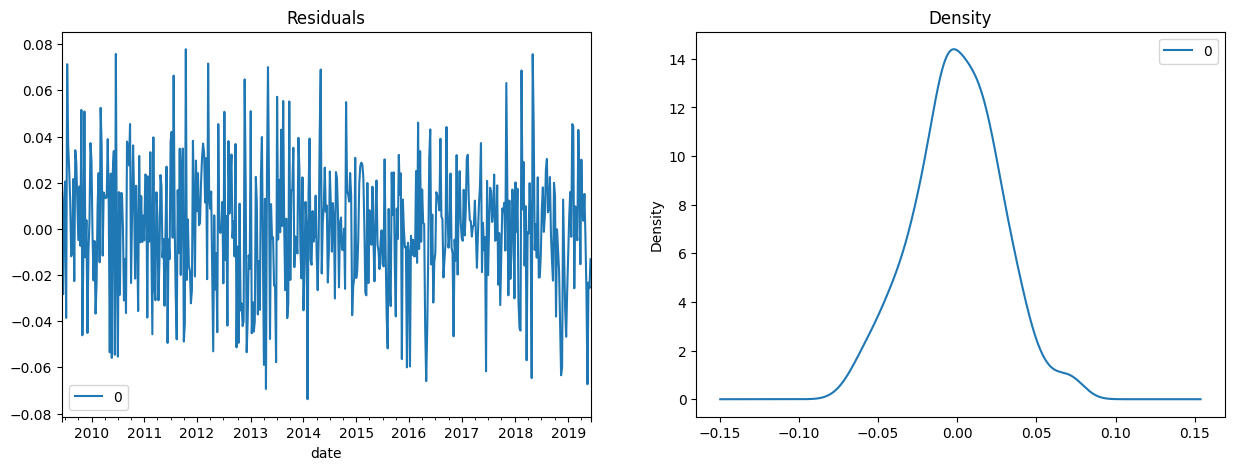

In [15]:
# Residual Analysis: to ensure they are randomly distributed (white noise).

residuals = pd.DataFrame(best_model.resid)
fig, ax = plt.subplots(1,2, figsize=(15,5))
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

Residual Plot: Shows how well the ARIMA model fits the data over time. The residuals (errors) fluctuate around zero without an obvious pattern, which is a good sign. It means the model's doing a decent job.

Density Plot: Shows the distribution of these residuals. Most residuals are close to zero and the shape of the plot looks roughly symmetric, which suggests that the residuals are normally distributed. This is also a positive indicator that the model’s assumptions hold true.

Both plots show that the ARIMA model has captured the data's structure well.

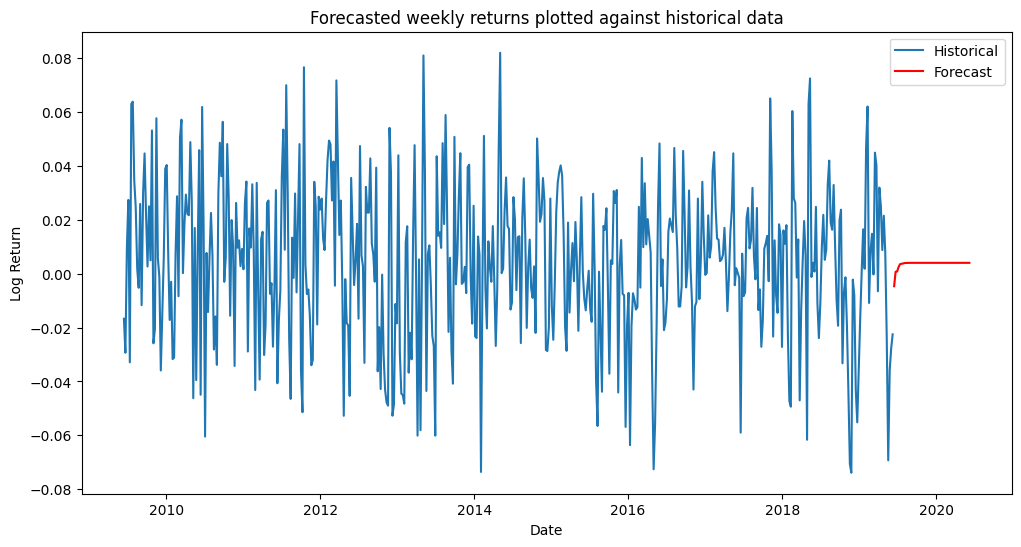

In [16]:
forecast_steps = 52
forecast = best_model.forecast(steps=forecast_steps)

plt.figure(figsize=(12, 6))
plt.plot(df_week['weekly_ret'], label='Historical')
plt.plot(forecast.index, forecast, label='Forecast', color='red')
plt.title('Forecasted weekly returns plotted against historical data')
plt.xlabel('Date')
plt.ylabel('Log Return')
plt.legend()
plt.show()

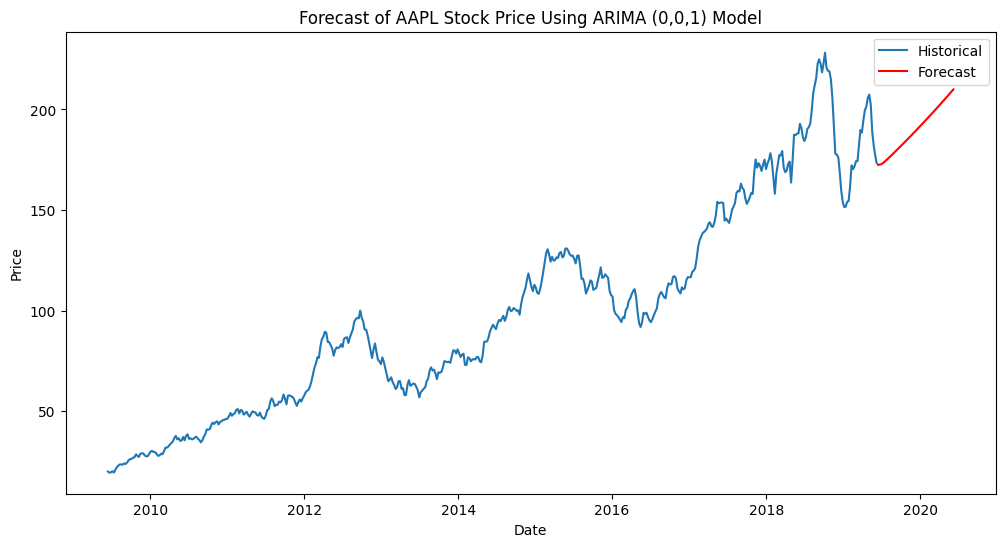

In [17]:
# Inverse Transform to Price: To make the forecast interpretable, we convert the returns back to price levels.
last_close = df_week['close'][-1]
forecast_prices = last_close * np.exp(np.cumsum(forecast))

plt.figure(figsize=(12, 6))
plt.plot(df_week['close'], label='Historical')
plt.plot(forecast.index, forecast_prices, label='Forecast', color='red')
plt.title('Forecast of AAPL Stock Price Using ARIMA (0,0,1) Model')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

In [18]:
# Print the forecasted values
print("Forecasted Returns for the Next 52 Weeks:")
print(forecast_prices)

Forecasted Returns for the Next 52 Weeks:
2019-06-16    172.495378
2019-06-23    172.623097
2019-06-30    172.760948
2019-07-07    173.181080
2019-07-14    173.797800
2019-07-21    174.439288
2019-07-28    175.102263
2019-08-04    175.795339
2019-08-11    176.499480
2019-08-18    177.207942
2019-08-25    177.922195
2019-09-01    178.641035
2019-09-08    179.363098
2019-09-15    180.088342
2019-09-22    180.816772
2019-09-29    181.548229
2019-10-06    182.282671
2019-10-13    183.020114
2019-10-20    183.760556
2019-10-27    184.503998
2019-11-03    185.250450
2019-11-10    185.999925
2019-11-17    186.752433
2019-11-24    187.507986
2019-12-01    188.266595
2019-12-08    189.028274
2019-12-15    189.793035
2019-12-22    190.560890
2019-12-29    191.331851
2020-01-05    192.105931
2020-01-12    192.883143
2020-01-19    193.663500
2020-01-26    194.447014
2020-02-02    195.233697
2020-02-09    196.023563
2020-02-16    196.816625
2020-02-23    197.612896
2020-03-01    198.412388
2020-03-

# Results and Findings
- The optimal ARIMA model identified was ARIMA(0, 0, 1), achieving the lowest MSE of 0.00057.
- The model's residuals are randomly distributed, signalling a good fit.
- The forecast indicates a specific upward trend in AAPL stock returns and prices over the upcoming 52 weeks(full 2024 year).
- The model successfully captures the data’s underlying patterns, but like any model, it comes with its limitations and assumptions.

# Conclusion
- I created a model using ARIMA with hyperparameter tuning to forecast AAPL's weekly stock returns. This highlights the critical role of data preparation, stationarity testing, and parameter optimization in time series forecasting. While the model offers valuable insights, it's important to recognize that stock markets are subject to many unpredictable factors, and no model can provide guaranteed predictions.